In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import copy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

df = pd.read_csv('data/boreal_rough.csv', header=None)
print(df)
# xs = df['Points:1']
xs = df[0]
# ys = df['Points:0']
ys = df[1]
    
traj = np.array([[x,y] for x,y in zip(xs,ys)])

print(traj)

FileNotFoundError: [Errno 2] File data/boreal_rough.csv does not exist: 'data/boreal_rough.csv'

In [3]:
#from https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
def compute_curvature(traj, nn=1):
    """
    traj : n x 2 array of x and y coords
    nn : number of nearest neighbors to consider
    """
    
    x_t = np.zeros(len(xs))
    y_t = np.zeros(len(ys))

    for i in range(nn, traj.shape[0]-nn):
        h_s = 0
        h_d = 0
        for j in range(0, nn):
            h_s = h_s + np.linalg.norm(traj[i-j, 0:2] - traj[i-j-1, 0:2])
            h_d = h_d + np.linalg.norm(traj[i+j+1, 0:2] - traj[i+j, 0:2])

        x_t[i] = (h_s**2 * traj[i-nn, 0] + (h_d**2 - h_s**2) * traj[i, 0] - h_d**2 * traj[i+nn, 0]) / (h_s*h_d*(h_s + h_d))
        y_t[i] = (h_s**2 * traj[i-nn, 1] + (h_d**2 - h_s**2) * traj[i, 1] - h_d**2 * traj[i+nn, 1]) / (h_s*h_d*(h_s + h_d))

    xx_t = np.zeros(traj.shape[0])
    yy_t = np.zeros(traj.shape[0])
    for i in range(nn, traj.shape[0]-nn):
        h_s = 0
        h_d = 0
        for j in range(0, nn):
            h_s = h_s + np.linalg.norm(traj[i-j, 0:2] - traj[i-j-1, 0:2])
            h_d = h_d + np.linalg.norm(traj[i+j+1, 0:2] - traj[i+j, 0:2])
        xx_t[i] = (h_s**2 * x_t[i-nn] + (h_d**2 - h_s**2) * x_t[i] - h_d**2 * x_t[i+nn]) / (h_s*h_d*(h_s + h_d))
        yy_t[i] = (h_s**2 * y_t[i-nn] + (h_d**2 - h_s**2) * y_t[i] - h_d**2 * y_t[i+nn]) / (h_s*h_d*(h_s + h_d))

    cur = np.zeros((traj.shape[0]))
    for i in range(0, cur.shape[0]):
        cur[i] = np.sqrt(xx_t[i]**2 + yy_t[i]**2)

    return cur

In [4]:
def dist(p1,p2):
    return np.sqrt(np.sum([(e1-e2)**2 for e1,e2 in zip(p1,p2)]))
    
def smooth_lowpass(traj, n=1):
    """
    traj : n x 2 array of x and y coords
    n: number of neighbors on the left and right (i.e., 2n neighbors in total)
    """
    traj_smoothed = copy.copy(traj)
    
    for i in range(n,len(traj)-n):
        traj_smoothed[i] = 0.5*traj[i]
        s = 0
        total_dist=0
        for j in range(i-n,i+n+1):#[i-n;i+n]
            s += traj[j]
            total_dist += 1
        traj_smoothed[i] = 1./total_dist*s
    
    return traj_smoothed
    

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9a4555fc50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9a454ee278>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9a4555fa58>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9a454ee828>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9a454eeb00>,
 'means': []}

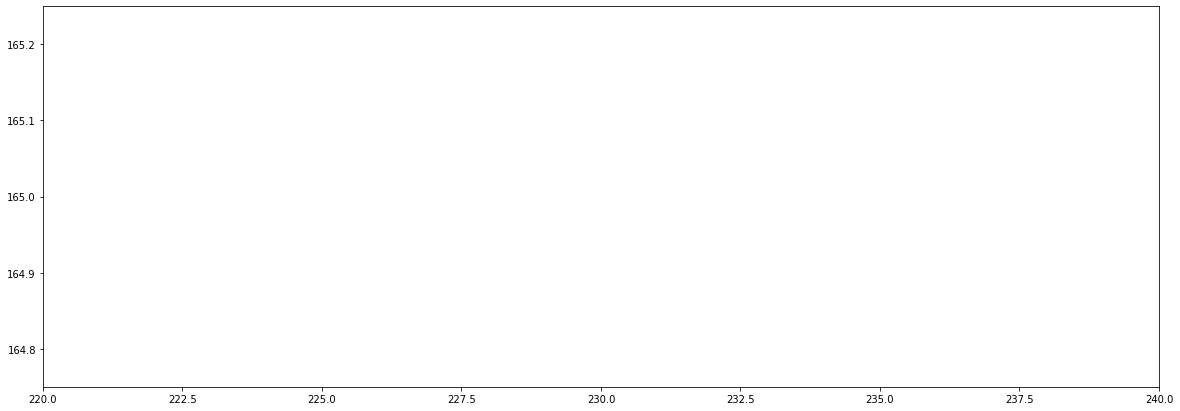

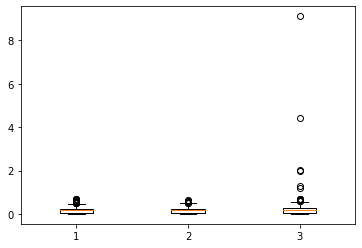

In [5]:
nn_cur=10


# plot traj
plt.figure(figsize=(20,7))
plt.scatter(traj[:,0], traj[:,1], s=20, marker='o', color='k', alpha=.5)
plt.ylim(-100,200)
# plt.axis('equal')
# plt.plot(cur)

#highlight points with curvature above x% quartile
cur = compute_curvature(traj, nn_cur)
max_ok = np.quantile(cur, .9)
points_not_ok = np.array([traj[i] for i in range(len(traj)) if cur[i]>max_ok])
plt.scatter(points_not_ok[:,0], points_not_ok[:,1], s=200, marker='o', color='r', alpha=.3)

#smooth and plot smooth
traj_smooth = smooth_lowpass(traj, 5)
plt.plot(traj_smooth[:,0], traj_smooth[:,1], color='g', alpha=.5)

#zoom
plt.xlim(220,240)
plt.ylim(164.75,165.25)

#plot curvatures
cur_smoothed_nn = compute_curvature(traj_smooth, nn_cur)
cur_smoothed_no_nn = compute_curvature(traj_smooth, 1)

plt.figure()
plt.boxplot([ cur,
              cur_smoothed_nn,
              cur_smoothed_no_nn],
           )
# plt.ylim(0,1.5*max_ok)



In [6]:
print(traj_smooth)

df[0] = traj_smooth[:, 0]
df[1] = traj_smooth[:, 1]

df.to_csv('data/ltr/boreal_smoothed.csv', header=None, index=False)

[[ 2.32131000e-01  4.22495000e-01]
 [ 2.86299000e-01  4.14021000e-01]
 [ 3.67268000e-01  4.07842000e-01]
 [ 4.64873000e-01  3.97533000e-01]
 [ 5.21920000e-01  3.91251000e-01]
 [ 5.97751909e-01  3.84989636e-01]
 [ 6.77303636e-01  3.77692091e-01]
 [ 7.61010091e-01  3.70400273e-01]
 [ 8.56013909e-01  3.62693818e-01]
 [ 9.52052727e-01  3.54802545e-01]
 [ 1.05300636e+00  3.46478636e-01]
 [ 1.15915636e+00  3.37429000e-01]
 [ 1.27068782e+00  3.27991000e-01]
 [ 1.38776873e+00  3.18291273e-01]
 [ 1.50264245e+00  3.08945545e-01]
 [ 1.62235273e+00  2.98880545e-01]
 [ 1.74526273e+00  2.87999091e-01]
 [ 1.87131182e+00  2.76898182e-01]
 [ 1.99898000e+00  2.65260182e-01]
 [ 2.11906909e+00  2.54181182e-01]
 [ 2.24241091e+00  2.42100000e-01]
 [ 2.38015182e+00  2.28234455e-01]
 [ 2.52037636e+00  2.14638000e-01]
 [ 2.66112273e+00  2.00728273e-01]
 [ 2.80382818e+00  1.86517364e-01]
 [ 2.94906909e+00  1.72245273e-01]
 [ 3.09554727e+00  1.58333027e-01]
 [ 3.24303091e+00  1.43945000e-01]
 [ 3.39086455e+00  1

(500,)


ValueError: Input passed into argument "'x'"is not 1-dimensional.

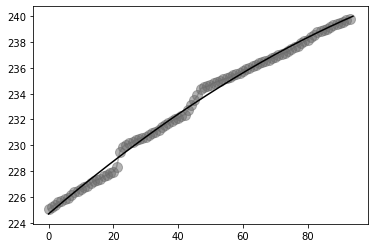

In [231]:
sigma_noise=1 #[m]
#get subsample of points with bounding box
traj_ss = np.array([p for p in traj if 225<p[0]<240 and 164<p[1]<166])
# plt.axis('equal')

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(range(len(traj_ss))).T
y = traj_ss

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0,len(traj_ss),500)).T

# Instantiate a Gaussian Process model
kernel = C() * RBF()
gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_noise ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

print(sigma.shape)

plt.figure()
ax = plt.gca()

ax.plot(X[:,0], y[:,0], 'dimgray', marker='o', markersize=10, label='Observations', alpha=.5)
ax.plot(x[:,0], y_pred[:,0], 'k', label='Prediction')
ax.fill_between(x[:0],
                y_pred[:,0] - 1.9600 * sigma,
                y_pred[:,0] + 1.9600 * sigma,
         alpha=.5, fc='gray', ec='None', label='95\% confidence interval')
ax.set_xlabel('$x$')